# Evaluate and predict customer churn

This notebook is an adaptation from the work done by [Sidney Phoon and Eleva Lowery](https://github.com/IBMDataScience/DSX-DemoCenter/tree/master/DSX-Local-Telco-Churn-master) with the following modifications:

* Use datasets persisted in DB2 Warehouse running on ICP
* Use additional datasets from multiple datasources such as Cloudant on public cloud, and Amazon S3
* Use of Watson Data Platform for data ingestion and preparation (using Data Refinery)
* Deploy and run the notebook on DSX enterprise running on IBM Cloud Private (ICP)
* Run spark Machine learning job on ICP as part of the worker nodes.
* Document some actions for a beginner data scienctist / developer who wants to understand what's going on.
* The web application was separated in another git project

The goal is to demonstrate how to build a predictive model with Spark machine learning API (SparkML) to predict customer churn, and deploy it for scoring in Machine Learning (ML) running on ICP or within IBM public Cloud, Watson Machine Learning service.

## Scope

A lot of industries have the issue of customers moving to competitors when the product differentiation is not that important, or there is some customer support issues. One industry illustrating this problem is the telecom industry with mobile, internet and IP TV product offerings.

## Note book explanations

The notebook aims to follow the classical data science modeling steps:

load the data
prepare the data
analyze the data (iterate on those two activities)
build a model
validate the accuracy of the model
deploy the model
consume the model as a service

This jupyter notebook uses Apache Spark to run the machine learning jobs to build decision trees and random forest classifier to assess when a customer is at risk to move to competitor. Apache Spark offers a Python module called pyspark to operate on data and use ML constructs.

### Start by all imports
As a best practices for notebook implementation is to do the import at the top of the notebook. 
* [Spark SQLContext](https://spark.apache.org/docs/latest/sql-programming-guide.html) a spark module to process structured data
* [spark conf]() to access Spark cluster configuration and then be able to execute queries
* [jaydebeapi](https://pypi.python.org/pypi/JayDeBeApi) is used to connect to the DB 2 warehouse where customer data are persisted. We assume they are loaded.
* [ibmdbpy](https://pypi.python.org/pypi/ibmdbpy) interface for data manipulation and access to in-database algorithms in IBM dashDB and IBM DB2.
* [pandas](https://pandas.pydata.org) Python super library for data analysis
* [brunel](https://github.com/Brunel-Visualization/Brunel/wiki) API and tool to visualize data quickly. 
* [pixiedust](www.ibm.com/PixieDust) Visualize data inside Jupyter notebooks

The first cell below is to execute some system commands to update the kernel with updated dependant library.

In [1]:
# The following will be needed if you want to download datasets from outside the WDP environment for any reason. But we won't be needing this in the current sample exercise
!pip install --upgrade wget

Requirement already up-to-date: wget in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages


In [2]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages
Requirement already up-to-date: astunparse in /usr/local/src/conda3_runtime.v27/4.1.1/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: markdown in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages (from pixiedust)
Requirement alread

In [4]:
!pip install --upgrade watson-machine-learning-client

    100% |████████████████████████████████| 317kB 2.1MB/s eta 0:00:01
Requirement already up-to-date: lomond in /usr/local/src/conda3_runtime.v27/4.1.1/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /usr/local/src/conda3_runtime.v27/4.1.1/lib/python3.5/site-packages (from watson-machine-learning-client)
    100% |████████████████████████████████| 61kB 7.7MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 7.5MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 6.0MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 25.7MB 48kB/s  eta 0:00:01    43% |█████████████▉                  | 11.1MB 48.0MB/s eta 0:00:01
Requirement already up-to-date: six>=1.10.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s796-0c7a8ec08c3a1c-8b16cafc4fd4/.local/lib/python3.5/site-packages (from lomond->watson-machine-learning-client)
    10

In [7]:
import pyspark
import pandas as pd
import brunel
import numpy as np
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.types import DecimalType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import LongType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pixiedust.display import *

## Load data using Watson Data Platform (WDP)

Watson Data platform (WDP) can be used to bring in data from multiple sources including but not limited to, files, datastores on cloud as well as on premises. WDP includes features to connect to data sources, bring in the data, refine, and then perform analytics.

In this sample are using WDP approach. We connect to Amazon S3, Cloudant on IBM public (or private) cloud, and DB2 Data Warehouse on IBM public or private cloud. Once we bring in the data, we refine / cleanse them using Data Refinery and export the result as a CSV file for training analytical model. These steps are already accomplished using WDP so that we can start loading that data for analytics in the following cells.

In [31]:
# Load customer information along with churn status. We read this from the CSV file prepared for training purposes
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '0iYlgkldtINM5my_68CDOlxU5Ts0E7dn0wJkYCs6bqOp',
    'service_id': 'iam-ServiceId-de6a2704-3436-4927-8ceb-a2e3dfc3288e',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_d21bf0a6588f494d822173729799c934_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_customer_transactions = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('data_asset/YTc2MDUyNjAtYzg5OC00MDk5LTgyZGItYThlZjI4ZDczNmZl_data_6283e5af-2e69-426e-b327-1a3bbc23ded3.csv', 'customerchurnproject86ce96f6a9384a669a14bd5dd9b3028e'))
df_customer_transactions.take(5)
df_customer_transactions.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Children: string (nullable = true)
 |-- Est Income: string (nullable = true)
 |-- Car Owner: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- LongDistance: string (nullable = true)
 |-- International: string (nullable = true)
 |-- Local: string (nullable = true)
 |-- Dropped: string (nullable = true)
 |-- Paymethod: string (nullable = true)
 |-- LocalBilltype: string (nullable = true)
 |-- LongDistanceBilltype: string (nullable = true)
 |-- Usage: string (nullable = true)
 |-- RatePlan: string (nullable = true)
 |-- DeviceOwned: string (nullable = true)
 |-- CHURN: string (nullable = true)



In [36]:
# Load the call notes dataset
df_call_notes = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('data_asset/MTIwYWQwZDctMmMyMC00NTkzLWI3YjItNDI4NGVjMzhlYjA5_data_0601330c-2331-46df-b9bc-df5ab0eb9a41.csv', 'customerchurnproject86ce96f6a9384a669a14bd5dd9b3028e'))
df_call_notes.take(5)
df_call_notes.describe()
df_call_notes.show(25)

+--------------------+---+------------+-------------+----------+
|            Comments| ID|    Keyword1|     Keyword2|Sentiments|
+--------------------+---+------------+-------------+----------+
|Asked about stora...|  1|         sim|      storage|analytical|
|Asked about low-e...|  6|basic config|   smartphone|analytical|
|Dissatisfied with...|  8|   promotion|       rebate|frustrated|
|Asked about low-e...| 11|basic config|   smartphone|analytical|
|Asked about low-e...| 14|basic config|   smartphone|analytical|
|Dissatisfied with...| 17|   promotion|       rebate|frustrated|
|Asked about low-e...| 18|basic config|   smartphone|analytical|
|Asked about low-e...| 21|basic config|   smartphone|analytical|
|Upset about the d...| 22|   data plan|        speed|frustrated|
|Asked about low-e...| 23|basic config|   smartphone|analytical|
|Asked how to inst...| 24|     sd card|         apps|analytical|
|Asked how to inst...| 29|     sd card|         apps|analytical|
|Said his battery ...| 35

In [37]:
# Load customer campaign responses dataset
df_campaign_responses = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('data_asset/MmQwNjUxYmUtYjU3My00ZmViLTk0YWEtYTc5ZWExZmU3Mjg3_data_e26e9c54-7143-449c-bbf4-71998290d86a.csv', 'customerchurnproject86ce96f6a9384a669a14bd5dd9b3028e'))
df_campaign_responses.take(5)


[Row(CUSTOMERID='6', Preference='android phone', Owns Multiple Phone Numbers='N', Ave Text Msgs='1807', Owns Multiple Lines='0'),
 Row(CUSTOMERID='8', Preference='android phone', Owns Multiple Phone Numbers='N', Ave Text Msgs='1364', Owns Multiple Lines='0'),
 Row(CUSTOMERID='18', Preference='android phone', Owns Multiple Phone Numbers='N', Ave Text Msgs='1407', Owns Multiple Lines='0'),
 Row(CUSTOMERID='29', Preference='android phone', Owns Multiple Phone Numbers='N', Ave Text Msgs='1043', Owns Multiple Lines='0'),
 Row(CUSTOMERID='37', Preference='android phone', Owns Multiple Phone Numbers='N', Ave Text Msgs='841', Owns Multiple Lines='0')]

##### The next few steps involve a series of data preparation tasks such as filling the missing values, joining datasets etc. The following cell fills the null values for average SMS count. Note that this can be accomplished by using Data Refinery, but the following snippet is shown to iullustrate the API way of accomplishing the same.

In [38]:
df_campaign_responses = df_campaign_responses.na.fill({'Ave Text Msgs':'0'})

##### In the following cell we join some of our data sources. Note that we could have done some of these using Data Refinery on Watson Data Platform using GUI support.

In [39]:
data_joined_callnotes_churn = df_call_notes.join(df_customer_transactions,df_call_notes['ID']==df_customer_transactions['ID'],'inner').select(df_call_notes['Sentiments'],df_call_notes['Keyword1'],df_call_notes['Keyword2'],df_customer_transactions['*'])
data_joined_callnotes_churn_campaign = df_campaign_responses.join(data_joined_callnotes_churn,df_campaign_responses['CUSTOMERID']==data_joined_callnotes_churn['ID'],'inner').select(data_joined_callnotes_churn['*'],df_campaign_responses['Preference'],df_campaign_responses['Owns Multiple Phone Numbers'],df_campaign_responses['Ave Text Msgs'])
data_joined_callnotes_churn_campaign.take(10)

[Row(Sentiments='analytical', Keyword1='sd card', Keyword2='apps', ID='24', Gender='F', Status='M', Children='2', Est Income='47902.00', Car Owner='N', Age='26.033333', Marital Status='Married', zipcode=None, LongDistance='17.44', International='4.94', Local='49.92', Dropped='1', Paymethod='Auto', LocalBilltype='FreeLocal', LongDistanceBilltype='Standard', Usage='72.31', RatePlan='2', DeviceOwned='moto', CHURN='F', Preference='more storage', Owns Multiple Phone Numbers='N', Ave Text Msgs='1864'),
 Row(Sentiments='frustrated', Keyword1='battery', Keyword2='new phone', ID='35', Gender='F', Status='S', Children='0', Est Income='78851.30', Car Owner='N', Age='48.373333', Marital Status='Single', zipcode=None, LongDistance='0.37', International='0.00', Local='28.66', Dropped='0', Paymethod='CC', LocalBilltype='FreeLocal', LongDistanceBilltype='Standard', Usage='29.04', RatePlan='4', DeviceOwned='ipho', CHURN='T', Preference='dual sim', Owns Multiple Phone Numbers='Y', Ave Text Msgs='1173'),

##### The following code block is intended to get a feel for Spark DataFrame APIs. We attempt to fix some of the column titles to promote readability, and also remove a duplicate column (Status and Marital Status are the same).  Finally convert the DataFrame to Python Pandas structure for visualization. Since all are string types from the CSV file, let us change some of them to other types

In [40]:
# Change some column names

data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("Sentiments", "Sentiment").withColumnRenamed("Owns Multiple Phone Numbers","OMPN")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("Keyword1", "Keyword_Component").withColumnRenamed("Keyword2","Keyword_Query")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("Ave Text Msgs", "SMSCount").withColumnRenamed("Car Owner","CarOwnership")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("Marital Status", "MaritalStatus").withColumnRenamed("Est Income","Income")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.drop('Status')

# Change some of the data types

data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Children", data_joined_callnotes_churn_campaign["Children"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Income", data_joined_callnotes_churn_campaign["Income"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Age", data_joined_callnotes_churn_campaign["Age"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("LongDistance", data_joined_callnotes_churn_campaign["LongDistance"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("International", data_joined_callnotes_churn_campaign["International"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Local", data_joined_callnotes_churn_campaign["Local"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Dropped", data_joined_callnotes_churn_campaign["Dropped"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("Usage", data_joined_callnotes_churn_campaign["Usage"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("RatePlan", data_joined_callnotes_churn_campaign["RatePlan"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("SMSCount", data_joined_callnotes_churn_campaign["SMSCount"].cast(IntegerType()))
data_joined_callnotes_churn_campaign.show(10)
data_joined_callnotes_churn_campaign.printSchema()

pandas_df_callnotes_campaign_churn = data_joined_callnotes_churn_campaign.toPandas()
pandas_df_callnotes_campaign_churn.head(12)

+----------+-----------------+-------------+---+------+--------+------+------------+---+-------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----------+-----+-------------+----+--------+
| Sentiment|Keyword_Component|Keyword_Query| ID|Gender|Children|Income|CarOwnership|Age|MaritalStatus|zipcode|LongDistance|International|Local|Dropped|Paymethod|LocalBilltype|LongDistanceBilltype|Usage|RatePlan|DeviceOwned|CHURN|   Preference|OMPN|SMSCount|
+----------+-----------------+-------------+---+------+--------+------+------------+---+-------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----------+-----+-------------+----+--------+
|analytical|          sd card|         apps| 24|     F|       2| 47902|           N| 26|      Married|   null|          17|            5|   50|      1|     Auto|    FreeLocal|            Standard|   72|       2|       moto|   

,Sentiment,Keyword_Component,Keyword_Query,ID,Gender,Children,Income,CarOwnership,Age,MaritalStatus,...,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,DeviceOwned,CHURN,Preference,OMPN,SMSCount
0,analytical,sd card,apps,24,F,2,47902,N,26,Married,...,Auto,FreeLocal,Standard,72,2,moto,F,more storage,N,1864
1,frustrated,battery,new phone,35,F,0,78851,N,48,Single,...,CC,FreeLocal,Standard,29,4,ipho,T,dual sim,Y,1173
2,frustrated,battery,new phone,37,F,0,83892,Y,61,Married,...,CH,Budget,Standard,74,4,ipho,T,android phone,N,841
3,frustrated,battery,new phone,38,F,2,28221,N,38,Married,...,CC,FreeLocal,Standard,39,4,ipho,T,windows phone,N,1779
4,frustrated,battery,new phone,40,F,0,28589,N,15,Single,...,CC,FreeLocal,Standard,100,4,ipho,T,large display,N,1720
5,analytical,sd card,apps,45,M,2,89460,N,53,Single,...,CC,FreeLocal,Standard,36,2,ipho,T,more storage,N,1886
6,frustrated,technical,support,52,F,2,67388,N,53,Married,...,CC,Budget,Standard,96,3,ipho,T,android phone,N,1590
7,analytical,new number,customer care,53,F,1,57063,Y,52,Married,...,CH,Budget,Standard,98,4,ipho,F,android phone,N,1205
8,frustrated,technical,support,54,F,2,84166,N,54,Married,...,CC,Budget,Standard,15,2,ipho,T,dual sim,Y,1625
9,neutral,supervisor,delegation,61,M,2,100020,N,50,Single,...,CH,Budget,Standard,315,4,ipho,T,android phone,N,1696


##### The following brunel based visualization can also be performed from Data Refinery. Shown here to get the feel for APIs

In [41]:
%brunel data('pandas_df_callnotes_campaign_churn') bar y(#count) stack polar color(Sentiment) sort(#count) label(Sentiment, ' (', #count, '%)') tooltip(#all) percent(#count) legends(none)

<IPython.core.display.Javascript object>

In [42]:
%brunel data('pandas_df_callnotes_campaign_churn') bar x(Sentiment) y(#count) sort(#count) tooltip(#all)

<IPython.core.display.Javascript object>

In [43]:
%brunel data('pandas_df_callnotes_campaign_churn') treemap x(Keyword_Component) color(Keyword_Component) size(#count) label(Keyword_Query) tooltip(#all)

<IPython.core.display.Javascript object>

##### The following cell shows an example of how pixiedust can be used to build interactive dashboards, and how it can be exported out


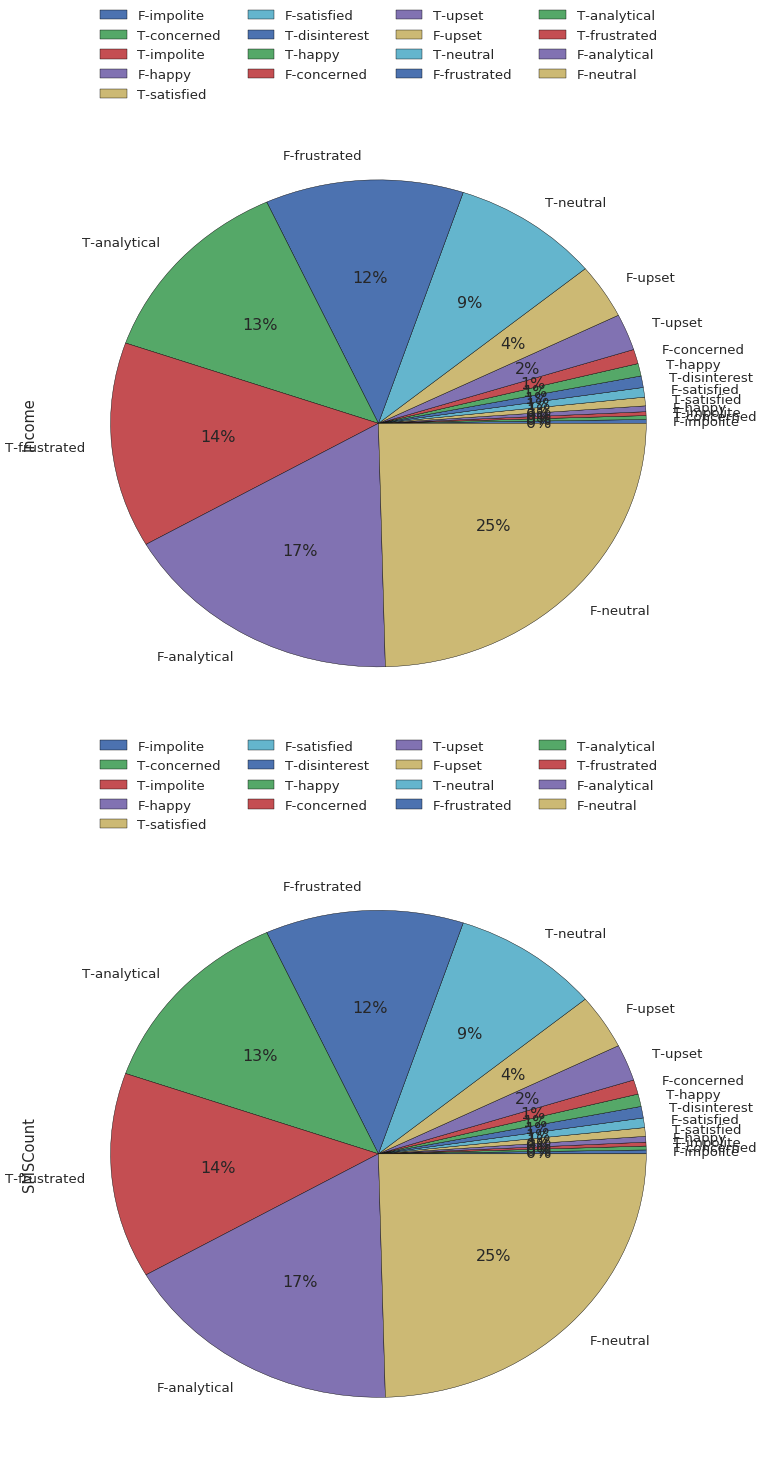

In [20]:
#display(pandas_df_callnotes_campaign_churn)
display(data_joined_callnotes_churn_campaign)

##### Building RandomForest based classifier

In [44]:
si_gender = StringIndexer(inputCol='Gender', outputCol='GenderIndexed',handleInvalid='error')
si_status = StringIndexer(inputCol='MaritalStatus',outputCol='MaritalStatusIndexed',handleInvalid='error')
si_carownership = StringIndexer(inputCol='CarOwnership',outputCol='CarOwnershipIndexed',handleInvalid='error')
#si_paymentmode = StringIndexer(inputCol='Paymethod',outputCol='PaymethodIndexed',handleInvalid='error')
si_localbill = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeIndexed',handleInvalid='error')
si_longdistancebill = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeIndexed',handleInvalid='error')
si_sentiment = StringIndexer(inputCol='Sentiment',outputCol='SentimentIndexed',handleInvalid='error')
si_multiplelines = StringIndexer(inputCol='OMPN',outputCol='OMPNIndexed',handleInvalid='error')
si_churnLabel = StringIndexer(inputCol='CHURN', outputCol='label',handleInvalid='error')
churnLabelIndexer = si_churnLabel.fit(data_joined_callnotes_churn_campaign)

#Apply OneHotEncoder so categorical features aren't given numeric importance
ohe_gender = OneHotEncoder(inputCol="GenderIndexed", outputCol="GenderIndexed"+"classVec")
ohe_maritalstatus = OneHotEncoder(inputCol="MaritalStatusIndexed", outputCol="MaritalStatusIndexed"+"classVec")
ohe_carownership = OneHotEncoder(inputCol="CarOwnershipIndexed", outputCol="CarOwnershipIndexed"+"classVec")
#ohe_paymentmode = OneHotEncoder(inputCol="PaymethodIndexed", outputCol="PaymethodIndexed"+"classVec")
ohe_localbill = OneHotEncoder(inputCol="LocalBilltypeIndexed", outputCol="LocalBilltypeIndexed"+"classVec")
ohe_longdistance = OneHotEncoder(inputCol="LongDistanceBilltypeIndexed", outputCol="LongDistanceBilltypeIndexed"+"classVec")
ohe_sentiment = OneHotEncoder(inputCol='SentimentIndexed', outputCol='SentimentIndexed'+'classVec')
ohe_multiplelines = OneHotEncoder(inputCol='OMPNIndexed', outputCol='OMPNIndexed'+'classVec')

assembler = VectorAssembler(inputCols=["GenderIndexedclassVec", "MaritalStatusIndexedclassVec", "CarOwnershipIndexedclassVec", "LocalBilltypeIndexedclassVec", \
                                       "LongDistanceBilltypeIndexedclassVec","SentimentIndexedclassVec","OMPNIndexedclassVec","Children", "Income", "Age", \
                                       "LongDistance", "International", "Local", "Dropped","SMSCount"], outputCol="features")

In [45]:
randomforest_classifier=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=churnLabelIndexer.labels)

pipeline = Pipeline(stages=[si_gender,si_status,si_carownership,si_localbill,si_longdistancebill,si_sentiment,si_multiplelines,churnLabelIndexer, ohe_gender,ohe_maritalstatus,ohe_carownership,ohe_localbill,ohe_longdistance,ohe_sentiment,ohe_multiplelines, assembler, randomforest_classifier, labelConverter])

##### Split the dataset into training and test using 70:30 split ratio and build the model

In [46]:
train, test = data_joined_callnotes_churn_campaign.randomSplit([0.7,0.3], seed=7)
train.cache()
test.cache()
model = pipeline.fit(train)

##### Testing the test dataset

In [47]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,1006,T,1.0,T,1.0,"[0.158660104946, 0.841339895054]"
1,1231,F,0.0,F,0.0,"[0.856550276104, 0.143449723896]"
2,1239,F,0.0,F,0.0,"[0.564429383217, 0.435570616783]"
3,1292,F,0.0,F,0.0,"[0.718433654577, 0.281566345423]"
4,1293,F,0.0,F,0.0,"[0.732433475527, 0.267566524473]"
5,1299,F,0.0,F,0.0,"[0.742578147566, 0.257421852434]"


##### Model Evaluation

In [48]:
prefix_precision = 'Precision model1 = {:.2f}.'
print (prefix_precision.format(results.filter(results.label == results.prediction).count() / float(results.count())))

prefix_aoc = 'Area under ROC curve = {:.2f}.'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print (prefix_aoc.format(evaluator.evaluate(results)))

Precision model1 = 0.88.
Area under ROC curve = 0.86.


##### Deployment in Watson Machine Learning. Note that there are multiple ways of deploying a model in WML. 

In [ ]:
from repository.mlrepositoryclient.ml_repository_client import MLRepositoryClient
from repository.mlrepositoryartifact.ml_repository_artifact import MLRepositoryArtifact
# Change the following lines to read from a file. Don't paste them here in plain text
service_path = 'https://ibm-watson-ml.mybluemix.net'
access_key = 'TIQq0il9oYIdVY938NboZNOwh6p3fwRYKdgDg0GFVFedaXXG3l3R77YHOsoPCk/oHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv'
username = '02f481c2-7717-4e79-b60f-3c1214b5f374'
password = 'f2f9349b-ebb5-4dfd-9318-94615a06fffb'

# Authorize the repository client
ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

model_artifact = MLRepositoryArtifact(model, training_data=train, name="Customer Churn Prediction")
saved_model = ml_repository_client.models.save(model_artifact)

# Print the saved model properties
print ("modelType: " + saved_model.meta.prop("modelType"))
print ("creationTime: " + str(saved_model.meta.prop("creationTime")))
print ("modelVersionHref: " + saved_model.meta.prop("modelVersionHref"))
print ("label: " + saved_model.meta.prop("label"))